In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

%run ../py/html_analysis.py


----
## Let's use the child strings data to build a NER system

In [139]:

def get_feature_tuple(feature_dict):
    feature_list = [feature_dict['initial_tag'], feature_dict['child_str']]
    is_header = feature_dict['is_header']
    if (is_header == True):
        if feature_dict['is_task_scope']:
            feature_list.append('H-TS')
        elif feature_dict['is_req_quals']:
            feature_list.append('H-RQ')
        elif feature_dict['is_preff_quals']:
            feature_list.append('H-PQ')
        elif feature_dict['is_legal_notifs']:
            feature_list.append('H-LN')
        elif feature_dict['is_job_title']:
            feature_list.append('H-JT')
        elif feature_dict['is_office_loc']:
            feature_list.append('H-OL')
        elif feature_dict['is_job_duration']:
            feature_list.append('H-JD')
        elif feature_dict['is_supp_pay']:
            feature_list.append('H-SP')
        elif feature_dict['is_educ_reqs']:
            feature_list.append('H-ER')
        elif feature_dict['is_interv_proc']:
            feature_list.append('H-IP')
        elif feature_dict['is_corp_scope']:
            feature_list.append('H-CS')
        elif feature_dict['is_post_date']:
            feature_list.append('H-PD')
        elif feature_dict['is_other']:
            feature_list.append('H-O')
    elif str(is_header) == 'nan':
        feature_list.append(np.nan)
    else:
        feature_list.append('O')

    return tuple(feature_list)

In [134]:

import random

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
feature_dict = random.choice(feature_dict_list)
get_feature_tuple(feature_dict)

('b', '<b>Duties included but not limited to:</b>', 'H-TS')


## Train an LDA Model to use as one of the features

In [371]:

%%time
def build_lda_predict_percent_fit():
    from gensim.corpora.dictionary import Dictionary
    from gensim.models.ldamodel import LdaModel
    
    # Build model with tokenized words
    sents_list = [sent_str for sublist in CHILD_STRS_LIST_DICT.values() for sent_str in sublist]
    tokenized_sents_list = [html_regex_tokenizer(sent_str) for sent_str in sents_list]
    
    # Create a corpus from a list of texts
    HEADERS_DICTIONARY = Dictionary(tokenized_sents_list)
    headers_corpus = [HEADERS_DICTIONARY.doc2bow(tag_str) for tag_str in tokenized_sents_list]
    
    # Train the model on the corpus
    LDA = LdaModel(corpus=headers_corpus, num_topics=2)
    
    # Define a predictor
    def predict_percent_fit(navigable_parent):
        X_test = HEADERS_DICTIONARY.doc2bow(html_regex_tokenizer(navigable_parent))
        result_list = LDA[X_test]
        if len(result_list) == 1:
            result_tuple = result_list[0]
        elif len(result_list) == 2:
            result_tuple = result_list[1]

        # Assume it's the probability of the smaller topic
        y_predict_proba = result_tuple[1]

        return y_predict_proba
    
    return predict_percent_fit
lda_predict_percent_fit = build_lda_predict_percent_fit()

Wall time: 32.5 s


In [372]:

CHILD_STRS_LIST_DICT = s.load_object('CHILD_STRS_LIST_DICT')
file_name, child_strs_list = random.choice(list(CHILD_STRS_LIST_DICT.items()))
navigable_parent = random.choice(child_strs_list)
print(navigable_parent)
lda_predict_percent_fit(navigable_parent)

<li>Ability to think creatively and critically and thrive in a fast-paced, dynamic, and often ambiguous work environment</li>


0.033679914


## Train an Logistic Regression Model to use as one of the features

In [373]:

%%time
def build_lr_predict_percent_fit():
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.linear_model import LogisticRegression
    
    # Re-transform the bag-of-words and tf-idf from the new manual scores
    BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
    rows_list = [{'navigable_parent': navigable_parent,
                  'is_header': is_header} for navigable_parent, is_header in BASIC_TAGS_DICT.items()]
    child_str_df = pd.DataFrame(rows_list)
    
    # Bag-of-words
    cv = CountVectorizer(**{'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'lowercase': False, 'max_df': 1.0,
                            'max_features': None, 'min_df': 0.0, 'ngram_range': (1, 5), 'stop_words': None, 'strip_accents': 'ascii',
                            'tokenizer': html_regex_tokenizer})
    
    # The shape of the count vector here should be n sentences * m unique words
    sents_list = child_str_df.navigable_parent.tolist()
    bow_matrix = cv.fit_transform(sents_list)
    
    # Tf-idf must get from Bag-of-words first
    CS_TT = TfidfTransformer(**{'norm': 'l1', 'smooth_idf': True, 'sublinear_tf': False, 'use_idf': True})
    tfidf_matrix = CS_TT.fit_transform(bow_matrix)
    
    # Re-train the classifier
    X = tfidf_matrix.toarray()
    y = child_str_df.is_header.to_numpy()
    FIT_ESTIMATORS_DICT = s.load_object('FIT_ESTIMATORS_DICT')
    CHILD_STR_CLF = FIT_ESTIMATORS_DICT['LogisticRegression']
    CHILD_STR_CLF.fit(X, y)
    
    # Re-calibrate the inference engine
    CS_CV = CountVectorizer(vocabulary=cv.vocabulary_)
    CS_CV._validate_vocabulary()
    
    def predict_percent_fit(navigable_parent):
        X_test = CS_TT.transform(CS_CV.transform([navigable_parent])).toarray()
        y_predict_proba = CHILD_STR_CLF.predict_proba(X_test)[0][1]
        
        return y_predict_proba
    
    return predict_percent_fit
lr_predict_percent_fit = build_lr_predict_percent_fit()

Wall time: 3.38 s


In [374]:

CHILD_STRS_LIST_DICT = s.load_object('CHILD_STRS_LIST_DICT')
file_name, child_strs_list = random.choice(list(CHILD_STRS_LIST_DICT.items()))
navigable_parent = random.choice(child_strs_list)
print(navigable_parent)
lr_predict_percent_fit(navigable_parent)

<li>Dataset cleaning</li>


0.0907600113875975

In [375]:

from itertools import groupby

%run ../py/tag_sets.py
inital_tag_sets_list = [document_body_elements_set, block_elements_set, basic_text_set, section_headings_set, lists_set,
                        other_block_elements_set, inline_elements_set, phrase_elements_set, presentation_set]
null_element = 'plaintext'
def word2features(sent, i):
    tag = sent[i][0]
    child_str = sent[i][1]
    postag = sent[i][2]
    
    features = {
        'bias': 1.0,
        'tag.document_body_elements_set': tag in document_body_elements_set,
        'tag.block_elements_set': tag in block_elements_set,
        'tag.basic_text_set': tag in basic_text_set,
        'tag.section_headings_set': tag in section_headings_set,
        'tag.lists_set': tag in lists_set,
        'tag.other_block_elements_set': tag in other_block_elements_set,
        'tag.inline_elements_set': tag in inline_elements_set,
        'tag.phrase_elements_set': tag in phrase_elements_set,
        'tag.presentation_set': tag in presentation_set,
        'tag.null_element': tag == null_element,
        'postag': postag,
        'child_str.lda': lda_predict_percent_fit(child_str),
        'child_str.lr': lr_predict_percent_fit(child_str),
    }
    if i > 0:
        tag1 = sent[i-1][0]
        postag1 = sent[i-1][2]
        features.update({
            '-1:tag.document_body_elements_set': tag1 in document_body_elements_set,
            '-1:tag.block_elements_set': tag1 in block_elements_set,
            '-1:tag.basic_text_set': tag1 in basic_text_set,
            '-1:tag.section_headings_set': tag1 in section_headings_set,
            '-1:tag.lists_set': tag1 in lists_set,
            '-1:tag.other_block_elements_set': tag1 in other_block_elements_set,
            '-1:tag.inline_elements_set': tag1 in inline_elements_set,
            '-1:tag.phrase_elements_set': tag1 in phrase_elements_set,
            '-1:tag.presentation_set': tag1 in presentation_set,
            '-1:tag.null_element': tag1 == null_element,
            '-1:postag': postag1,
            '-1:previous==tag': tag1 == tag,
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        tag1 = sent[i+1][0]
        postag1 = sent[i+1][2]
        features.update({
            '+1:tag.basic_text_set': tag1 in basic_text_set,
            '+1:tag.block_elements_set': tag1 in block_elements_set,
            '+1:tag.document_body_elements_set': tag1 in document_body_elements_set,
            '+1:tag.inline_elements_set': tag1 in inline_elements_set,
            '+1:tag.lists_set': tag1 in lists_set,
            '+1:tag.other_block_elements_set': tag1 in other_block_elements_set,
            '+1:tag.phrase_elements_set': tag1 in phrase_elements_set,
            '+1:tag.presentation_set': tag1 in presentation_set,
            '+1:tag.section_headings_set': tag1 in section_headings_set,
            '+1:tag.null_element': tag1 == null_element,
            '+1:postag': postag1,
            '+1:tag==previous': tag1 == tag,
        })
    else:
        features['EOS'] = True
        
    if i < len(sent)-2:
        tag1 = sent[i+1][0]
        tag2 = sent[i+2][0]
        postag2 = sent[i+2][2]
        labels_list = sent2labels(sent)[i:]
        consecutives_list = []
        for k, v in groupby(labels_list):
            consecutives_list.append((k, len(list(v))))
        if (consecutives_list[0][1] > 1):
            consecutive_next_tags = 0
        else:
            consecutive_next_tags = consecutives_list[1][1]
        features.update({
            '+2:tag.basic_text_set': tag2 in basic_text_set,
            '+2:tag.block_elements_set': tag2 in block_elements_set,
            '+2:tag.document_body_elements_set': tag2 in document_body_elements_set,
            '+2:tag.inline_elements_set': tag2 in inline_elements_set,
            '+2:tag.lists_set': tag2 in lists_set,
            '+2:tag.other_block_elements_set': tag2 in other_block_elements_set,
            '+2:tag.phrase_elements_set': tag2 in phrase_elements_set,
            '+2:tag.presentation_set': tag2 in presentation_set,
            '+2:tag.section_headings_set': tag2 in section_headings_set,
            '+2:tag.null_element': tag2 == null_element,
            '+2:postag': postag2,
            '+2:tag==previous': tag2 == tag1,
            'tag.consecutive_next_tags': consecutive_next_tags,
        })
    
    if i < len(sent)-3:
        tag2 = sent[i+2][0]
        tag3 = sent[i+3][0]
        postag3 = sent[i+3][2]
        features.update({
            '+3:tag.basic_text_set': tag3 in basic_text_set,
            '+3:tag.block_elements_set': tag3 in block_elements_set,
            '+3:tag.document_body_elements_set': tag3 in document_body_elements_set,
            '+3:tag.inline_elements_set': tag3 in inline_elements_set,
            '+3:tag.lists_set': tag3 in lists_set,
            '+3:tag.other_block_elements_set': tag3 in other_block_elements_set,
            '+3:tag.phrase_elements_set': tag3 in phrase_elements_set,
            '+3:tag.presentation_set': tag3 in presentation_set,
            '+3:tag.section_headings_set': tag3 in section_headings_set,
            '+3:tag.null_element': tag3 == null_element,
            '+3:postag': postag3,
            '+3:tag==previous': tag3 == tag2,
        })
    
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, child_str, label in sent]

def sent2tokens(sent):
    return [token for token, child_str, label in sent]


----
## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [376]:

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
sent = [get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
labels_list = sent2labels(sent)

In [377]:

features_dict = random.choice(sent2features(sent))
features_dict

{'bias': 1.0, 'tag.document_body_elements_set': True, 'tag.block_elements_set': True, 'tag.basic_text_set': False, 'tag.section_headings_set': False, 'tag.lists_set': True, 'tag.other_block_elements_set': False, 'tag.inline_elements_set': False, 'tag.phrase_elements_set': False, 'tag.presentation_set': False, 'tag.null_element': False, 'postag': 'O', 'child_str.lda': 0.029199587, 'child_str.lr': 0.08846901510605769, '-1:tag.document_body_elements_set': True, '-1:tag.block_elements_set': False, '-1:tag.basic_text_set': False, '-1:tag.section_headings_set': False, '-1:tag.lists_set': False, '-1:tag.other_block_elements_set': False, '-1:tag.inline_elements_set': True, '-1:tag.phrase_elements_set': True, '-1:tag.presentation_set': True, '-1:tag.null_element': False, '-1:postag': 'H-RQ', '-1:previous==tag': False, '+1:tag.basic_text_set': False, '+1:tag.block_elements_set': True, '+1:tag.document_body_elements_set': True, '+1:tag.inline_elements_set': False, '+1:tag.lists_set': True, '+1:ta

In [378]:

%%time
from sklearn.model_selection import train_test_split

all_sents = []
for file_name, feature_dict_list in HEADER_PATTERN_DICT.items():
    feature_dict_list = [get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
    all_sents.append(feature_dict_list)
X = [sent2features(s) for s in all_sents]
y = [sent2labels(s) for s in all_sents]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Wall time: 3.56 s


In [379]:

%%time
import sklearn_crfsuite

CRF = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
CRF.fit(X_train, y_train)
s.store_objects(CRF=CRF)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CRF.pickle
Wall time: 588 ms


## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [380]:

labels = list(CRF.classes_)
labels.remove('O')
labels

['H-TS', 'H-RQ', 'H-SP', 'H-JD', 'H-ER', 'H-PQ', 'H-CS', 'H-OL', 'H-LN', 'H-JT', 'H-PD', 'H-IP', 'H-O']

In [381]:

from sklearn_crfsuite import metrics

y_pred = CRF.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


0.9154135338345866

In [382]:

print(metrics.flat_classification_report(
    y_test, y_pred, labels=labels, digits=3
))

              precision    recall  f1-score   support

        H-TS      1.000     1.000     1.000         6
        H-RQ      0.900     1.000     0.947         9
        H-SP      1.000     1.000     1.000         1
        H-JD      1.000     1.000     1.000         4
        H-ER      1.000     1.000     1.000         1
        H-PQ      1.000     1.000     1.000         1
        H-CS      1.000     1.000     1.000         2
        H-OL      1.000     1.000     1.000         5
        H-LN      1.000     0.750     0.857         4
        H-JT      1.000     1.000     1.000         1
        H-PD      0.000     0.000     0.000         0
        H-IP      0.000     0.000     0.000         2
         H-O      0.000     0.000     0.000         0

   micro avg      0.971     0.917     0.943        36
   macro avg      0.762     0.750     0.754        36
weighted avg      0.919     0.917     0.915        36



C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['H-TS', 'H-RQ', 'H-SP', 'H-JD', 'H-ER', 'H-PQ', 'H-CS', 'H-OL', 'H-LN', 'H-JT', 'H-PD', 'H-IP', 'H-O'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Anaconda3\envs\jh\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [383]:

file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
feature_tuple_list = [get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
CRF = s.load_object('CRF')
prediction_dict_list = CRF.predict_marginals_single(sent2features(feature_tuple_list))
random.choice(prediction_dict_list)

{'O': 0.39803969004667655, 'H-TS': 0.07572579807179716, 'H-RQ': 0.03372962404457559, 'H-SP': 0.015306130968239228, 'H-JD': 0.03352888577304933, 'H-ER': 0.021003221658905787, 'H-PQ': 0.04831105437029, 'H-CS': 0.03832698494293811, 'H-OL': 0.06803753841725507, 'H-LN': 0.13848928346853126, 'H-JT': 0.024599643230201203, 'H-PD': 0.027809169001455795, 'H-IP': 0.024595777322944348, 'H-O': 0.05249719868314041}


----
## Make a Prediction Visualization

In [384]:

def plot_child_str_predictions(file_name, ax=None):
    child_strs_list = get_child_strs_from_file(file_name)
    HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
    if file_name in HEADER_PATTERN_DICT:
        feature_dict_list = HEADER_PATTERN_DICT[file_name]
        feature_tuple_list = [get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
        CRF = s.load_object('CRF')
        prediction_dict_list = []
        for prediction_dict in CRF.predict_marginals_single(sent2features(feature_tuple_list)):
            prediction_dict = {'H': 1 - prediction_dict['O']}
            prediction_dict_list.append(prediction_dict)
    else:
        prediction_dict_list = []
        for child_str in child_strs_list:
            y_predict_proba = predict_percent_fit([child_str])[0]
            if(CLF_NAME == 'LdaModel'):
                H = y_predict_proba
            else:
                H = y_predict_proba[0][1]
            prediction_dict = {'H': H}
            prediction_dict_list.append(prediction_dict)
    rows_list = []
    BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
    for child_str, marginals_dict in zip(child_strs_list, prediction_dict_list):
        row_dict = {'probability': marginals_dict['H']}
        if child_str in BASIC_TAGS_DICT:
            row_dict['actual'] = BASIC_TAGS_DICT[child_str] * 1.0
        else:
            row_dict['actual'] = np.nan
        rows_list.append(row_dict)
    df = pd.DataFrame(rows_list)
    coor = round(df.corr().loc['probability', 'actual'], 4)
    if (coor < 0.999) or (ax is not None):
        if ax is None:
            fig = plt.figure(figsize=(18, 2.5))
            ax = fig.add_subplot(1, 1, 1)
            title_text = fig.suptitle(t=f'Correlation to Actual: {coor}', y=1.55)
        AxesSubplot_obj = df.plot.line(ax=ax)
        ax.axis('off')
        for x, child_str in enumerate(child_strs_list):
            y = rows_list[x]['probability']
            if str(y) == 'nan':
                y = rows_list[x]['actual']
            if str(y) != 'nan':
                ax.annotate(f'{child_str[:20]}...', (x, y), ha='left', rotation=90)

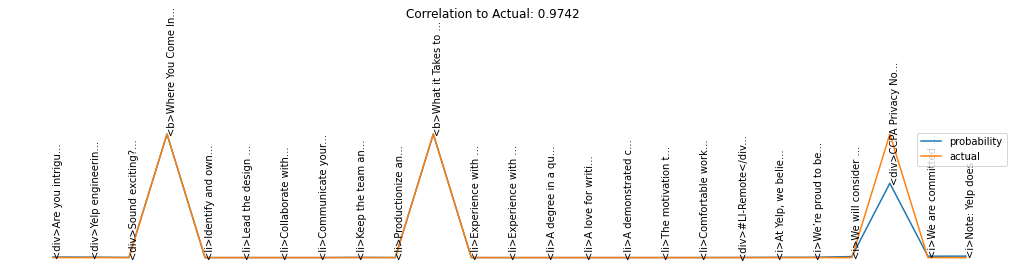

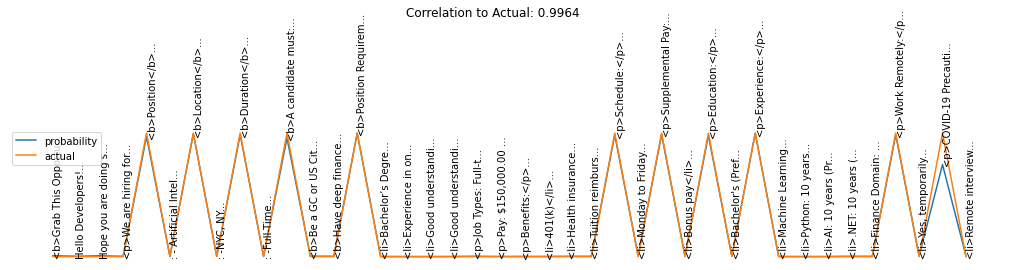

In [385]:

for file_name in list(HEADER_PATTERN_DICT.keys()):
    plot_child_str_predictions(file_name)


----
# Find the Basic Qualifications Section

In [428]:

def get_child_tags_list(child_strs_list):
    child_tags_list = []
    for navigable_parent in child_strs_list:
        tokenized_sent = html_regex_tokenizer(navigable_parent)
        try:
            first_token = tokenized_sent[0]
            if first_token[0] == '<':
                child_tags_list.append(first_token[1:])
            else:
                child_tags_list.append('plaintext')
        except:
            child_tags_list.append('plaintext')
    
    return child_tags_list

In [296]:

def get_is_header_list(child_strs_list):
    is_header_list = []
    BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
    for navigable_parent in child_strs_list:
        if navigable_parent in BASIC_TAGS_DICT:
            is_header = BASIC_TAGS_DICT[navigable_parent]
        else:
            is_header = np.nan
        is_header_list.append(is_header)
    
    return is_header_list

In [405]:

def get_idx_list(items_list, item_str):
    item_count = items_list.count(item_str)
    idx_list = []
    idx = -1
    while len(idx_list) < item_count:
        idx = items_list.index(item_str, idx+1)
        idx_list.append(idx)

    return idx_list

In [420]:

def display_basic_requirements(consecutives_list, pos_list, child_strs_list):
    rq_idx_list = get_idx_list(pos_list, 'H-RQ')
    if len(rq_idx_list):
        consecutives_idx_list = get_idx_list(consecutives_list, ('H-RQ', 1))
        for rq_idx, consecutives_idx in zip(rq_idx_list, consecutives_idx_list):
            o_count = consecutives_list[consecutives_idx+1][1]
            display(HTML(''.join(child_strs_list[rq_idx:rq_idx+o_count+1])))

In [414]:

def find_basic_quals_section(file_name):
    child_strs_list = get_child_strs_from_file(file_name)
    child_tags_list = get_child_tags_list(child_strs_list)
    is_header_list = get_is_header_list(child_strs_list)
    feature_dict_list = get_feature_dict_list(child_tags_list, is_header_list, child_strs_list)
    feature_tuple_list = [get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]
    CRF = s.load_object('CRF')
    crf_list = CRF.predict_single(sent2features(feature_tuple_list))
    pos_list = []
    BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
    for pos, feature_tuple in zip(crf_list, feature_tuple_list):
        navigable_parent = feature_tuple[1]
        if navigable_parent in BASIC_TAGS_DICT:
            if navigable_parent in TASK_SCOPE_HEADERS_LIST:
                pos_list.append('H-TS')
            elif navigable_parent in REQ_QUALS_HEADERS_LIST:
                pos_list.append('H-RQ')
            elif navigable_parent in PREFF_QUALS_HEADERS_LIST:
                pos_list.append('H-PQ')
            elif navigable_parent in LEGAL_NOTIFS_HEADERS_LIST:
                pos_list.append('H-LN')
            elif navigable_parent in JOB_TITLE_HEADERS_LIST:
                pos_list.append('H-JT')
            elif navigable_parent in OFFICE_LOC_HEADERS_LIST:
                pos_list.append('H-OL')
            elif navigable_parent in JOB_DURATION_HEADERS_LIST:
                pos_list.append('H-JD')
            elif navigable_parent in SUPP_PAY_HEADERS_LIST:
                pos_list.append('H-SP')
            elif navigable_parent in EDUC_REQS_HEADERS_LIST:
                pos_list.append('H-ER')
            elif navigable_parent in INTERV_PROC_HEADERS_LIST:
                pos_list.append('H-IP')
            elif navigable_parent in CORP_SCOPE_HEADERS_LIST:
                pos_list.append('H-CS')
            elif navigable_parent in POST_DATE_HEADERS_LIST:
                pos_list.append('H-PD')
            elif navigable_parent in OTHER_HEADERS_LIST:
                pos_list.append('H-O')
            else:
                pos_list.append('O')
        else:
            pos_list.append(pos)
    consecutives_list = []
    for k, v in groupby(pos_list):
        consecutives_list.append((k, len(list(v))))
    
    return consecutives_list, pos_list, feature_tuple_list, child_strs_list

In [390]:

navigable_parent = '<b>Job Duties and Responsibilities</b>'
navigable_parent in BASIC_TAGS_DICT

False

In [391]:

BASIC_TAGS_DICT[navigable_parent] = True
TASK_SCOPE_HEADERS_LIST.append(navigable_parent)
s.store_objects(BASIC_TAGS_DICT=BASIC_TAGS_DICT, TASK_SCOPE_HEADERS_LIST=TASK_SCOPE_HEADERS_LIST)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\BASIC_TAGS_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\TASK_SCOPE_HEADERS_LIST.pickle


In [431]:

files_list = os.listdir(SAVES_HTML_FOLDER)
file_name = random.choice(files_list)
while file_name in HEADER_PATTERN_DICT:
    file_name = random.choice(files_list)
consecutives_list, pos_list, feature_tuple_list, child_strs_list = find_basic_quals_section(file_name)
print(consecutives_list)
print(pos_list)
display_basic_requirements(consecutives_list, pos_list, child_strs_list)

[('H-LN', 1), ('O', 1), ('H-PD', 1), ('O', 1), ('H-ER', 1), ('O', 1), ('H-RQ', 1), ('O', 11), ('H-RQ', 1), ('O', 11), ('H-RQ', 1), ('O', 11), ('H-RQ', 1), ('O', 4), ('H-JD', 1), ('O', 1), ('H-RQ', 1), ('O', 2), ('H-OL', 1), ('O', 1)]
['H-LN', 'O', 'H-PD', 'O', 'H-ER', 'O', 'H-RQ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-RQ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-RQ', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'H-RQ', 'O', 'O', 'O', 'O', 'H-JD', 'O', 'H-RQ', 'O', 'O', 'H-OL', 'O']


In [432]:

pos_explanation_dict = s.load_object('pos_explanation_dict')
for pos_tuple in [(pos_explanation_dict[pos],
                   feature_tuple[1] if pos != 'O' else f'{feature_tuple[1][:50]}...') for pos, feature_tuple in zip(pos_list, feature_tuple_list)]:
    print(pos_tuple)

('Legal Notifications Header', '<b>Title:</b>')
('Non-header', 'Data Scientist...')
('Post Date Header', '<b>Location:</b>')
('Non-header', 'Remote...')
('Education Requirements Header', '<b>Duration:</b>')
('Non-header', 'Contract...')
('Required Qualifications Header', '<b>Objective of this Role:</b>')
('Non-header', '<li>Have worked in Retail side of Pharma Industry ...')
('Non-header', '<li>Hands-on experience working on medium &amp; la...')
('Non-header', '<li>Experience working in Agile (2-weeks sprint cy...')
('Non-header', '<li>Experience working on Code Reviews, Code Deplo...')
('Non-header', '<li>Familiarity to work in ensemble Modeling techn...')
('Non-header', '<li>Familiarity with Snowflake as model developmen...')
('Non-header', '<li>Collaborate with customer analytics teams to u...')
('Non-header', '<li>Communicate findings, issue statuses and resol...')
('Non-header', '<li>Smooth cross-functional coordination, enableme...')
('Non-header', '<li>Enable smarter business pr

In [127]:

[f'random.{fn}' for fn in dir(random) if 'int' in fn.lower()]

['random.randint']

In [138]:

is_header = feature_dict_list[idx]['is_header']
print((is_header == True), (str(is_header) == 'nan'))

nan True


In [34]:

text_editor_path = r'C:\Program Files\Notepad++\notepad++.exe'
file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
!"{text_editor_path}" "{os.path.abspath(file_path)}"

In [40]:

BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
rows_list = [{'navigable_parent': navigable_parent, 'is_header': is_header} for navigable_parent, is_header in BASIC_TAGS_DICT.items()]
child_str_df = pd.DataFrame(rows_list)
s.store_objects(child_str_df=child_str_df)
child_str_df = s.load_object('child_str_df')
child_str_df[child_str_df.is_header].navigable_parent.tolist()

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\child_str_df.pickle


['<b>Where You Come In:</b>', '<b>What it Takes to Succeed:</b>', '<div>CCPA Privacy Notice</div>', '<b>Position</b>', '<b>Location</b>', '<b>Duration</b>', '<b>A candidate must:</b>', '<b>Position Requirements:</b>', '<p>Schedule:</p>', '<p>Supplemental Pay:</p>', '<p>Education:</p>', '<p>Experience:</p>', '<p>Work Remotely:</p>', '<p>COVID-19 Precaution(s):</p>', '<p>Work Location:</p>', '<b>Responsibilities:</b>', '<b>Qualifications:</b>', '<b>Primary Responsibilities:</b>', '<b>Required Qualifications:</b>', '<b>Preferred Qualifications:</b>', '<b>Careers with Optum.</b>', '<h2 class="jobsearch-JobDescriptionSection-jobDescriptionTitle icl-u-xs-my--md" id="jobDescriptionTitle">Full Job Description</h2>', '<b>What will you do?</b>', '<b>What does your success look like in the first 90 days?</b>', '<b>What are we looking for?</b>', '<b>What skills, experiences, and education are required?</b>', '<b>Why LPL?</b>', '<b>Information on Interviews:</b>', '<b>Location and Travel:</b>', '<b


----

In [174]:

from pycrfsuite import ItemSequence

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
#sequence_obj_dict = {file_name: ItemSequence(feature_dict_list) for file_name, feature_dict_list in HEADER_PATTERN_DICT.items()}
file_name, feature_dict_list = random.choice(list(HEADER_PATTERN_DICT.items()))
sequence_obj = ItemSequence(feature_dict_list)
random.choice(sequence_obj.items())

{'initial_tag:p': 1.0, 'is_header': 1.0, 'is_task_scope': 0.0, 'is_req_quals': 0.0, 'is_preff_quals': 0.0, 'is_legal_notifs': 1.0, 'is_job_title': 0.0, 'is_office_loc': 0.0, 'is_job_duration': 0.0, 'is_supp_pay': 0.0, 'is_educ_reqs': 0.0, 'is_interv_proc': 0.0, 'is_corp_scope': 0.0, 'is_post_date': 0.0, 'is_other': 0.0, 'child_str:<p>Application Question:</p>': 1.0}


----
# Create the Header Pattern Dictionary

In [365]:

TASK_SCOPE_HEADERS_LIST = s.load_object('TASK_SCOPE_HEADERS_LIST')
REQ_QUALS_HEADERS_LIST = s.load_object('REQ_QUALS_HEADERS_LIST')
PREFF_QUALS_HEADERS_LIST = s.load_object('PREFF_QUALS_HEADERS_LIST')
LEGAL_NOTIFS_HEADERS_LIST = s.load_object('LEGAL_NOTIFS_HEADERS_LIST')
JOB_TITLE_HEADERS_LIST = s.load_object('JOB_TITLE_HEADERS_LIST')
OFFICE_LOC_HEADERS_LIST = s.load_object('OFFICE_LOC_HEADERS_LIST')
JOB_DURATION_HEADERS_LIST = s.load_object('JOB_DURATION_HEADERS_LIST')
SUPP_PAY_HEADERS_LIST = s.load_object('SUPP_PAY_HEADERS_LIST')
EDUC_REQS_HEADERS_LIST = s.load_object('EDUC_REQS_HEADERS_LIST')
INTERV_PROC_HEADERS_LIST = s.load_object('INTERV_PROC_HEADERS_LIST')
CORP_SCOPE_HEADERS_LIST = s.load_object('CORP_SCOPE_HEADERS_LIST')
POST_DATE_HEADERS_LIST = s.load_object('POST_DATE_HEADERS_LIST')
OTHER_HEADERS_LIST = s.load_object('OTHER_HEADERS_LIST')
def get_feature_dict_list(child_tags_list, is_header_list, child_strs_list):
    feature_dict_list = [{'initial_tag': tag, 'is_header': is_header,
                          'is_task_scope': child_str in TASK_SCOPE_HEADERS_LIST,
                          'is_req_quals': child_str in REQ_QUALS_HEADERS_LIST,
                          'is_preff_quals': child_str in PREFF_QUALS_HEADERS_LIST,
                          'is_legal_notifs': child_str in LEGAL_NOTIFS_HEADERS_LIST,
                          'is_job_title': child_str in JOB_TITLE_HEADERS_LIST,
                          'is_office_loc': child_str in OFFICE_LOC_HEADERS_LIST,
                          'is_job_duration': child_str in JOB_DURATION_HEADERS_LIST,
                          'is_supp_pay': child_str in SUPP_PAY_HEADERS_LIST,
                          'is_educ_reqs': child_str in EDUC_REQS_HEADERS_LIST,
                          'is_interv_proc': child_str in INTERV_PROC_HEADERS_LIST,
                          'is_corp_scope': child_str in CORP_SCOPE_HEADERS_LIST,
                          'is_post_date': child_str in POST_DATE_HEADERS_LIST,
                          'is_other': child_str in OTHER_HEADERS_LIST,
                          'child_str': child_str} for tag, is_header, child_str in zip(child_tags_list, is_header_list, child_strs_list)]
    
    return feature_dict_list

In [366]:

from bs4 import BeautifulSoup
import re
%run ../load_magic/storage.py
s = Storage()

SAVES_HTML_FOLDER = os.path.join(s.saves_folder, 'html')
files_list = os.listdir(SAVES_HTML_FOLDER)

%run ../py/html_analysis.py

assert s.pickle_exists('CHILD_STRS_LIST_DICT')
CHILD_STRS_LIST_DICT = s.load_object('CHILD_STRS_LIST_DICT')
assert s.pickle_exists('BASIC_TAGS_DICT')
BASIC_TAGS_DICT = s.load_object('BASIC_TAGS_DICT')
HEADER_PATTERN_DICT = {}
for file_name in files_list:
    if file_name in CHILD_STRS_LIST_DICT:
        child_strs_list = CHILD_STRS_LIST_DICT[file_name]
    else:
        file_path = os.path.join(SAVES_HTML_FOLDER, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_str = f.read()
            job_soup = BeautifulSoup(html_str, 'lxml')
            body_soup = job_soup.find_all(name='body')[0]
            child_strs_list = get_navigable_children(body_soup, [])
    navigable_parent = child_strs_list[0]
    if navigable_parent not in BASIC_TAGS_DICT:
        continue
    child_tags_list = []
    is_header_list = []
    for navigable_parent in child_strs_list:
        if navigable_parent not in BASIC_TAGS_DICT:
            break
        tokenized_sent = html_regex_tokenizer(navigable_parent)
        try:
            first_token = tokenized_sent[0]
            if first_token[0] == '<':
                child_tags_list.append(first_token[1:])
            else:
                child_tags_list.append('plaintext')
        except:
            child_tags_list.append('plaintext')
        is_header = BASIC_TAGS_DICT[navigable_parent]
        is_header_list.append(is_header)
    if len(child_tags_list) == len(child_strs_list):
        if file_name not in CHILD_STRS_LIST_DICT:
            CHILD_STRS_LIST_DICT[file_name] = child_strs_list
            s.store_objects(CHILD_STRS_LIST_DICT=CHILD_STRS_LIST_DICT)
        if file_name not in HEADER_PATTERN_DICT:
            item_sequence = get_feature_dict_list(child_tags_list, is_header_list, child_strs_list)
            HEADER_PATTERN_DICT[file_name] = item_sequence
            s.store_objects(HEADER_PATTERN_DICT=HEADER_PATTERN_DICT)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CHILD_STRS_LIST_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CHILD_STRS_LIST_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CHILD_STRS_LIST_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CHILD_STRS_LIST_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\CHILD_STRS_LIST_DICT.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\HEADER_PATTERN_DICT.pi

In [4]:

import sys

command_str = f'{sys.executable} -m pip install --upgrade sklearn-crfsuite'
print(command_str)
!{command_str}

C:\Users\dev\Anaconda3\envs\jh\python.exe -m pip install --upgrade sklearn-crfsuite


In [175]:

TASK_SCOPE_HEADERS_LIST = ['<b>Where You Come In:</b>', '<b>Responsibilities:</b>', '<b>Primary Responsibilities:</b>',
                           '<h2 class="jobsearch-JobDescriptionSection-jobDescriptionTitle icl-u-xs-my--md" id="jobDescriptionTitle">' +
                           'Full Job Description</h2>', '<b>What will you do?</b>',
                           '<b>What does your success look like in the first 90 days?</b>',
                           '<b>Job Summary</b>', '<b>Core Responsibilities</b>', '<b>Duties included but not limited to:</b>',
                           'Translate / Interpret:', 'Measure / Quantify / Expand:', 'Explore / Enlighten:', '<b>Responsibilities</b>',
                           '<div>Key responsibilities in this role include:</div>', 'Overview:', 'Responsibilities:',
                           '<b>This means you will:</b>',
                           '<b>ROLE SUMMARY</b>', '<b>ROLE RESPONSIBILITIES</b>', '<b>Key Responsibilities</b>', '<b>Description</b>',
                           '<b>Overview</b>', '<b>Summary</b>', '<b>Principal Duties &amp; Responsibilities</b>']
REQ_QUALS_HEADERS_LIST = ['<b>What it Takes to Succeed:</b>', '<b>A candidate must:</b>', '<b>Position Requirements:</b>',
                          '<p>Experience:</p>', '<b>Qualifications:</b>', '<b>Required Qualifications:</b>',
                          '<b>What skills, experiences, and education are required?</b>', '<b>Qualifying Experience</b>', '<b>Requirements:</b>',
                          '<b>Qualifications</b>', 'Qualifications:', 'Minimum Skill Qualifications', '<b>To do that, this mean you have:</b>',
                          '<b>QUALIFICATIONS</b>', '<b>Job Qualifications</b>', '<b>Work Experience</b>', '<b>License and Certifications</b>',
                          '<b>Skills, Abilities &amp; Competencies</b>']
PREFF_QUALS_HEADERS_LIST = ['<b>Preferred Qualifications:</b>', '<b>What are we looking for?</b>', '<b>The Ideal Candidate will:</b>',
                            '<p>You are...</p>', '<b>And we love people who:</b>', '<b>A strong candidate will also have</b>']
LEGAL_NOTIFS_HEADERS_LIST = ['<div>CCPA Privacy Notice</div>', '<p>Application Question:</p>', '<b>EOE Statement:</b>', '<b>Sunshine Act</b>',
                             '<b>EEO &amp; Employment Eligibility</b>', '<b>EEO Statement</b>']
JOB_TITLE_HEADERS_LIST = ['<b>Position</b>']
OFFICE_LOC_HEADERS_LIST = ['<b>Location</b>', '<p>Work Remotely:</p>', '<p>Work Location:</p>', '<b>Location and Travel:</b>', '<b>Travel :</b>',
                           '<b>Working Conditions</b>', '<b>Primary Location</b>', '<b>Work Locations</b>']
JOB_DURATION_HEADERS_LIST = ['<b>Duration</b>', '<p>Schedule:</p>', '<b>Employee Status :</b>', '<b>Shift :</b>']
SUPP_PAY_HEADERS_LIST = ['<p>Supplemental Pay:</p>', '<b>Options</b>']
EDUC_REQS_HEADERS_LIST = ['<p>Education:</p>', '<b>Education</b>']
INTERV_PROC_HEADERS_LIST = ['<p>COVID-19 Precaution(s):</p>']
CORP_SCOPE_HEADERS_LIST = ['<b>Careers with Optum.</b>', '<b>Why LPL?</b>', '<b>Information on Interviews:</b>', "<p>Company's website:</p>",
                           '<b>Patients First | Innovation | Winning Culture | Heart Recovery</b>',
                           '<b>Cogito Business Intelligence Developer, Enterprise Data &amp; Digital Health</b>']
POST_DATE_HEADERS_LIST = ['<b>Job Posting :</b>']
OTHER_HEADERS_LIST = ['<div>Share</div>']
s.store_objects(TASK_SCOPE_HEADERS_LIST=TASK_SCOPE_HEADERS_LIST, REQ_QUALS_HEADERS_LIST=REQ_QUALS_HEADERS_LIST,
                PREFF_QUALS_HEADERS_LIST=PREFF_QUALS_HEADERS_LIST, LEGAL_NOTIFS_HEADERS_LIST=LEGAL_NOTIFS_HEADERS_LIST,
                JOB_TITLE_HEADERS_LIST=JOB_TITLE_HEADERS_LIST, OFFICE_LOC_HEADERS_LIST=OFFICE_LOC_HEADERS_LIST,
                JOB_DURATION_HEADERS_LIST=JOB_DURATION_HEADERS_LIST, SUPP_PAY_HEADERS_LIST=SUPP_PAY_HEADERS_LIST,
                EDUC_REQS_HEADERS_LIST=EDUC_REQS_HEADERS_LIST, INTERV_PROC_HEADERS_LIST=INTERV_PROC_HEADERS_LIST,
                CORP_SCOPE_HEADERS_LIST=CORP_SCOPE_HEADERS_LIST, POST_DATE_HEADERS_LIST=POST_DATE_HEADERS_LIST,
                OTHER_HEADERS_LIST=OTHER_HEADERS_LIST)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\TASK_SCOPE_HEADERS_LIST.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\REQ_QUALS_HEADERS_LIST.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\PREFF_QUALS_HEADERS_LIST.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\LEGAL_NOTIFS_HEADERS_LIST.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\JOB_TITLE_HEADERS_LIST.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\OFFICE_LOC_HEADERS_LIST.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\JOB_DURATION_HEADERS_LIST.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\SUPP_PAY_HEADERS_LIST.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\EDUC_REQS_HEADERS_LIST.pickle
Pickling to C:\Users\dev\Documents\Repositories\job-hunting\save

In [148]:

pos_explanation_dict = {}
pos_explanation_dict['H-TS'] = 'Task Scope Header'
pos_explanation_dict['H-RQ'] = 'Required Qualifications Header'
pos_explanation_dict['H-PQ'] = 'Preferred Qualifications Header'
pos_explanation_dict['H-LN'] = 'Legal Notifications Header'
pos_explanation_dict['H-JT'] = 'Job Title Header'
pos_explanation_dict['H-OL'] = 'Office Location Header'
pos_explanation_dict['H-JD'] = 'Job Duration Header'
pos_explanation_dict['H-SP'] = 'Supplemental Pay Header'
pos_explanation_dict['H-ER'] = 'Education Requirements Header'
pos_explanation_dict['H-IP'] = 'Interview Procedures Header'
pos_explanation_dict['H-CS'] = 'Corporate Scope Header'
pos_explanation_dict['H-PD'] = 'Post Date Header'
pos_explanation_dict['H-O'] = 'Other Header'
pos_explanation_dict['O'] = 'Non-header'
s.store_objects(pos_explanation_dict=pos_explanation_dict)

Pickling to C:\Users\dev\Documents\Repositories\job-hunting\saves\pickle\pos_explanation_dict.pickle
